In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import matplotlib.pyplot as plt
import os
import numpy as onp
import pandas as pd

import scipy
import time

# for reproducibility of results
random_state = 3101
onp.random.seed(random_state)

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# data = pd.read_csv("../data/DSA3101_Hackathon_Data.csv", parse_dates=[1])
# data = pd.read_csv("/content/drive/My Drive/data/DSA3101_Hackathon_Data.csv", parse_dates=[1])
data = pd.read_csv("/content/drive/My Drive/data/imputed_data.csv", parse_dates=[1], names=['Panel ID', 'Date', 'Category', 'Pack Size', 'Volume', 'Spend'], skiprows=1)

data['Volume'] = onp.where(data['Category']=='Eggs', data['Volume']*0.06, data['Volume'])    # eggs weigh around 60g
data['Volume'] = onp.where(data['Category']=='Instant Noodles', data['Volume']*0.06, data['Volume'])    # coincidentally instant noodles also weigh around 60g
# data = data[(data.Volume != 0) & (data.Spend != 0) & (data['Pack Size'] != 0)].sort_values('Date')
data['Ratio'] = round(data.Spend/data.Volume, 2)
data['Product'] = data["Category"] + "_" + data["Ratio"].astype(str)
data = data.sort_values("Date")
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend,Ratio,Product
700869,Panel 317007101,2017-06-25,Frozen Food,1,0.5,5.8,11.6,Frozen Food_11.6
723051,Panel 322018102,2017-06-25,Flour,1,1.0,3.7,3.7,Flour_3.7
723052,Panel 322018102,2017-06-25,Cooking Oils,2,2.0,5.0,2.5,Cooking Oils_2.5
724326,Panel 323010101,2017-06-25,Snack,5,0.1,2.0,20.0,Snack_20.0
724327,Panel 323010101,2017-06-25,Snack,5,0.1,2.0,20.0,Snack_20.0


In [2]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['Week'] = le.fit_transform(data.Date)
data.head()

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# data.to_csv("/content/drive/My Drive/data/data.csv", index=False)
# data.to_csv("../data/data.csv", index=False)

,Panel ID,Date,Category,Pack Size,Volume,Spend,Ratio,Product,Week
700869,Panel 317007101,2017-06-25,Frozen Food,1,0.5,5.8,11.6,Frozen Food_11.6,0
723051,Panel 322018102,2017-06-25,Flour,1,1.0,3.7,3.7,Flour_3.7,0
723052,Panel 322018102,2017-06-25,Cooking Oils,2,2.0,5.0,2.5,Cooking Oils_2.5,0
724326,Panel 323010101,2017-06-25,Snack,5,0.1,2.0,20.0,Snack_20.0,0
724327,Panel 323010101,2017-06-25,Snack,5,0.1,2.0,20.0,Snack_20.0,0


In [3]:
num_product = len(data.Product.unique())
num_panel = len(data['Panel ID'].unique())
print(f"Number of Product:{num_product} \t Number of Panels:{num_panel}")

Number of Product:36237 	 Number of Panels:3236


In [4]:
%%time

# def week_EMA(x):
#   lst = x.shift(-1)-x
#   return lst.ewm(com=1).mean().tail(1).values

# def spend_EMA(x):
#   return x.ewm(com=1).mean().tail(1).values

# ratings = data.groupby(by=["Panel ID", "Product"]).agg({
#     'Week': ['min', 'max', week_EMA], 'Spend': ['min', 'max', spend_EMA]}).reset_index()
# ratings.columns = ['Panel ID', 'Product', 'min_week', 'max_week', 'week_EMA', 'min_spend', 'max_spend', 'spend_EMA']
# ratings.fillna(0, inplace=True)
# ratings['Recency'] = ratings.max_week/155
# ratings['Frequency'] = (ratings.max_week - ratings.min_week - ratings.week_EMA)/(ratings.max_week - ratings.min_week)
# ratings['Monetary'] = onp.where(ratings.max_spend!=ratings.min_spend, (ratings.spend_EMA - ratings.min_spend)/(ratings.max_spend - ratings.min_spend), 1)
# ratings.fillna(0, inplace=True)
# ratings['RFM'] = ratings['Recency'] * ratings['Frequency'] * ratings['Monetary'] * 10

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# ratings.to_csv("/content/drive/My Drive/data/ratings.csv", index=False)
# ratings.to_csv("../data/ratings.csv", index=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [5]:
%%time
# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
ratings = pd.read_csv("/content/drive/My Drive/data/ratings.csv")
# ratings = pd.read_csv("../data/ratings.csv")

CPU times: user 709 ms, sys: 60.8 ms, total: 770 ms
Wall time: 3.68 s


In [6]:
ratings.RFM.min(), ratings.RFM.max()

(0.0, 9.99463377350611)

In [7]:
# in the generation of test set, it will only be useful when the panel has at least bought 4 products
# so we will perform the split here before conducting the train test split later on
panels_for_train_test_split = ratings['Panel ID'].value_counts()[ratings['Panel ID'].value_counts() >= 4].index    # panels who have at least bought 4 products before
panels_for_train = ratings['Panel ID'].value_counts()[ratings['Panel ID'].value_counts() < 4].index    # panels who have bought < 4 products before
products_for_train = ratings['Product'].value_counts()[ratings['Product'].value_counts() < 4].index

df = ratings[ratings['Panel ID'].isin(panels_for_train_test_split)]
train = ratings[['Panel ID', 'Product', 'RFM']][ratings['Panel ID'].isin(panels_for_train)]
df.shape, train.shape

((681908, 12), (41, 3))

In [8]:
from sklearn.model_selection import train_test_split

# X = ratings.loc[:,['Panel ID', 'Product']]
# y = ratings.RFM
X_train, X_test, y_train, y_test = train_test_split(
    df[['Panel ID', 'Product']], df.RFM, test_size=0.25, random_state=random_state, stratify=df['Panel ID'])    # if we do not split based on 4, stratify does not work

In [9]:
X_train.shape, X_test.shape

((511431, 2), (170477, 2))

In [10]:
train = train.append(X_train.assign(RFM=y_train.values))
test = X_test.assign(RFM=y_test.values)
train = train.append(test[test.Product.isin(products_for_train)])
test = test[~test.Product.isin(products_for_train)]
train = train.append(test[~test.Product.isin(train.Product.unique())])    # add products with only 1 record back to the training set
test = test[test.Product.isin(train.Product.unique())]
pivot = train.pivot_table(index='Panel ID', columns='Product', values='RFM')
global_mean = onp.nanmean(pivot)
subset = onp.where(onp.isfinite(pivot.values))
pivot

Product,Baby Cereal_102.0,Baby Cereal_11.0,Baby Cereal_113.9,Baby Cereal_12.0,Baby Cereal_12.67,Baby Cereal_13.6,Baby Cereal_134.5,Baby Cereal_14.0,Baby Cereal_14.2,Baby Cereal_14.5,Baby Cereal_15.0,Baby Cereal_15.8,Baby Cereal_152.0,Baby Cereal_16.0,Baby Cereal_16.6,Baby Cereal_169.0,Baby Cereal_17.65,Baby Cereal_17.67,Baby Cereal_17.8,Baby Cereal_18.0,Baby Cereal_18.33,Baby Cereal_18.6,Baby Cereal_18.8,Baby Cereal_18.83,Baby Cereal_19.0,Baby Cereal_19.2,Baby Cereal_19.8,Baby Cereal_19.83,Baby Cereal_20.0,Baby Cereal_20.2,Baby Cereal_20.29,Baby Cereal_20.33,Baby Cereal_20.6,Baby Cereal_20.75,Baby Cereal_20.8,Baby Cereal_20.9,Baby Cereal_20.91,Baby Cereal_21.0,Baby Cereal_21.18,Baby Cereal_21.2,...,Yoghurts_8.62,Yoghurts_8.67,Yoghurts_8.71,Yoghurts_8.73,Yoghurts_8.75,Yoghurts_8.78,Yoghurts_8.8,Yoghurts_8.82,Yoghurts_8.83,Yoghurts_8.89,Yoghurts_8.91,Yoghurts_8.93,Yoghurts_80.0,Yoghurts_9.0,Yoghurts_9.08,Yoghurts_9.09,Yoghurts_9.11,Yoghurts_9.14,Yoghurts_9.17,Yoghurts_9.2,Yoghurts_9.23,Yoghurts_9.25,Yoghurts_9.29,Yoghurts_9.3,Yoghurts_9.33,Yoghurts_9.4,Yoghurts_9.43,Yoghurts_9.5,Yoghurts_9.6,Yoghurts_9.62,Yoghurts_9.67,Yoghurts_9.71,Yoghurts_9.75,Yoghurts_9.78,Yoghurts_9.8,Yoghurts_9.83,Yoghurts_9.87,Yoghurts_9.9,Yoghurts_9.93,Yoghurts_9.96
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panel 101011101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101016101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101019101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101024101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 105009103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Panel 801900701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 801901201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [11]:
train.shape, test.shape, pivot.shape

((519467, 3), (162536, 3), (3236, 36237))

In [12]:
print(test.shape[0]/(train.shape[0]+test.shape[0]))
print(f"Sparsity: {train.shape[0]/(35590*3236)}")

0.2383215323099752
Sparsity: 0.004510466509981311


In [13]:
%%time
# naive models
def naive(x, dat=test):
    if x == 'global mean':
        return onp.sqrt(onp.sum((dat.RFM.values - global_mean)**2) / dat.shape[0])
    cost = 0
    if x == 'panel mean':
        df = pd.DataFrame({'Panel ID': pivot.index, 
                           'panel_mean': onp.nanmean(pivot, 1)})
        df = dat.merge(df, how="left", on="Panel ID")
        cost += onp.sum((df.RFM - df.panel_mean)**2)
    elif x == 'product mean':
        df = pd.DataFrame({'Product': pivot.columns, 
                           'product_mean': onp.nanmean(pivot, 0)})
        df = dat.merge(df, how="left", on="Product")
        cost += onp.sum((df.RFM - df.product_mean)**2)
    return np.sqrt(cost/dat.shape[0])

# Using global mean
naive_global_mean = naive('global mean')
print('RMSE using global mean:', naive_global_mean)
      
# Using Panel mean
naive_panel_mean = naive('panel mean')
print('RMSE using Panel mean:', naive_panel_mean)

# Using Category mean
naive_product_mean = naive('product mean')
print('RMSE using Product mean:', naive_product_mean)

RMSE using global mean: 1.5924904029995939
RMSE using Panel mean: 1.5594148376457675
RMSE using Product mean: 1.5515747837021063
CPU times: user 1.5 s, sys: 222 ms, total: 1.72 s
Wall time: 2.45 s


In [14]:
%%time
# number of factors (latent variables)
d = 30

# start optimisation from this
U_init = onp.random.normal(onp.sqrt(global_mean/d), scale=1/onp.sqrt(num_panel*d), size=(num_panel, d))
V_init = onp.random.normal(onp.sqrt(global_mean/d), scale=1/onp.sqrt(num_product*d), size=(num_product, d))
print("global mean:{0:.5f} \t minimum entry of U_init@V_init.T:{1:.5f} \t maximum entry of U_init@V_init.T:{2:.5f}".format(
    global_mean, onp.min(U_init@V_init.T), onp.max(U_init@V_init.T)))

def loss(U,V, reg = 1):
    cost = np.sum((pivot.values[subset] - (U @ V.T)[subset])**2)
    return cost/train.shape[0] + reg/num_panel*np.linalg.norm(U)**2 + reg/num_product*np.linalg.norm(V)**2

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

global mean:0.50860 	 minimum entry of U_init@V_init.T:0.49810 	 maximum entry of U_init@V_init.T:0.51913
CPU times: user 1.27 s, sys: 156 ms, total: 1.43 s
Wall time: 770 ms


iter: 0 - time: 16.818208932876587 - loss: 2.3771423909924176
iter: 1 - time: 24.623038291931152 - loss: 2.30556675249515
iter: 2 - time: 31.015650987625122 - loss: 2.2972157058498746
iter: 3 - time: 37.123597621917725 - loss: 2.284850320227655
iter: 4 - time: 45.05915832519531 - loss: 2.2628407883711477
iter: 5 - time: 51.041183948516846 - loss: 2.2459110891405136
iter: 6 - time: 56.968910455703735 - loss: 2.231801322177679
iter: 7 - time: 62.5335636138916 - loss: 2.222582287151735
iter: 8 - time: 67.40304160118103 - loss: 2.2170102599054227
iter: 9 - time: 72.58559703826904 - loss: 2.213506952732867
iter: 10 - time: 77.78320455551147 - loss: 2.211196007711128
iter: 11 - time: 82.69252586364746 - loss: 2.2096584707013234
iter: 12 - time: 87.55542325973511 - loss: 2.2086662610096592
iter: 13 - time: 89.5511109828949 - loss: 2.2084909950250893
iter: 14 - time: 91.1619565486908 - loss: 2.2084909950250893
iter: 15 - time: 92.79401707649231 - loss: 2.2084909950250893
iter: 16 - time: 94.41

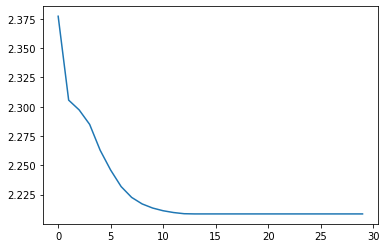

In [15]:
%%time
#let us define a function that does a few steps of LBFGS with U fixed
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(num_product, d)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(num_product, d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    
    V_final = traj["x"].reshape(num_product, d)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(num_panel,d)
    return U_final

U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 50
n_iter = 30
loss_history_train = []
start = time.time()

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_val = loss(U,V)
    loss_history_train.append(loss_val)
    print(f"iter: {_} - time: {time.time()-start} - loss: {loss_val}")

# gradient descent plot
plt.plot(loss_history_train)

In [16]:
# Using global mean
print(naive('global mean', train))
# Using Panel mean
print(naive('panel mean', train))
# Using Category mean
print(naive('product mean', train))

print(loss(U,V,0)**0.5)
print(1 - loss(U,V,0)**0.5 / naive('product mean', train))

1.545642238123381
1.5066932203502992
1.475540698282175
1.3209511361267552
0.10476807744807937


In [17]:
(U@V.T).min(), (U@V.T).max()

(-1.597605334955909, 11.108719595392687)

In [18]:
%%time

test_pivot = test.pivot_table(index='Panel ID', columns='Product', values='RFM')
test_pivot = pd.concat([test_pivot, pd.DataFrame(columns=list(pivot.columns[~pivot.columns.isin(test_pivot.columns)]))])
test_pivot = test_pivot.append(pd.DataFrame(index=pivot.index[~pivot.index.isin(test_pivot.index)]))
test_pivot.sort_index(axis = 0, inplace=True)
test_pivot.sort_index(axis = 1, inplace=True)

test_subset = onp.where(onp.isfinite(test_pivot.values.astype(onp.float)))

def RMSE(U,V):
    cost = onp.sum((test_pivot.values[test_subset] - (U @ V.T)[test_subset])**2)
    return onp.sqrt(cost/test.shape[0])

error = RMSE(U, V)
print(f"RMSE(test): {round(error, 3)}")

RMSE(test): 1.522
CPU times: user 13.3 s, sys: 1.61 s, total: 14.9 s
Wall time: 14.5 s


In [19]:
%%time
print(f"Improvement from Worst Naive Model (Using Global Mean) by {round(100*(1 - error/naive_global_mean), 1)}%")
print(f"Improvement from Naive Model (Using Panel Mean) by {round(100*(1 - error/naive_panel_mean), 1)}%")
print(f"Improvement from Best Naive Model (Using Product Mean) by {round(100*(1 - error/naive_product_mean), 1)}%")
print(f"Improvement from Worst to Best Naive Model by {round(100*(1 - naive_product_mean/naive_global_mean), 1)}%")

Improvement from Worst Naive Model (Using Global Mean) by 4.4%
Improvement from Naive Model (Using Panel Mean) by 2.4%
Improvement from Best Naive Model (Using Product Mean) by 1.9%
Improvement from Worst to Best Naive Model by 2.6%
CPU times: user 55 ms, sys: 118 ms, total: 173 ms
Wall time: 513 ms


In [20]:
user_df = pd.DataFrame(U, columns=[f"X{i}" for i in range(1, d+1)], index=pivot.index)

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# user_df.to_csv("../models/U30.csv")
# user_df.to_csv("/content/drive/My Drive/models/U30.csv")

prod_df = pd.DataFrame(V, columns=[f"X{i}" for i in range(1, d+1)], index=pivot.columns)

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# prod_df.to_csv("/content/drive/My Drive/models/V30.csv")
# prod_df.to_csv("../models/V30.csv")

# NOTE: Windows have no support for JAX library!
# choose path depending on platform (google colab or linux/macOS) 
# data[['Product', 'Category']].drop_duplicates() \
#   .merge(pd.DataFrame(V, columns=[f"X{i}" for i in range(1, d+1)], index=pivot.columns), on="Product") \
#   .to_csv("/content/drive/My Drive/models/V30_df.csv", index=False)

# panel_demo = pd.read_excel("/content/drive/My Drive/data/DSA3101_Hackathon_Panelists_Demographics.xlsx")
# user_df = user_df.merge(panel_demo, how='left', left_on=user_df.index, right_on='ID')
# user_df.set_index('ID').to_csv("/content/drive/My Drive/models/U30_df.csv")